In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os
from pathlib import Path

params = {"axes.titlesize": 14,
          "axes.labelsize": 14,
          "font.size": 14,
          "xtick.labelsize": 14,
          "ytick.labelsize": 14,
          "legend.fontsize": 14,
          "savefig.bbox": "tight"}
plt.rcParams.update(params)

%matplotlib inline

In [2]:
tmpfile = "tmp.txt"
df = pd.DataFrame(columns=["serie", "dep", "delai"])

for decret in Path(".").glob("decrets/*.pdf"):
    print(f"Process {decret}...")
    date = str(decret).partition("joe_")[2].partition("_")[0]
    decret_date = datetime.datetime.strptime(date, "%Y%m%d")
    with open(tmpfile, "w") as f:
        subprocess.check_call(["pdf2txt.py", decret], stdout=f)
    
    with open(tmpfile) as f:
        content = f.read()
        keys = ["\n\n", ", \n"]
        for key in keys:
            content = content.replace(key, "\n")
        content = content.replace("\ndép", ", dép")
        content = content.replace("X \n", "X")
        lines = content.split("\n")
    
    for line in lines:
        if "NAT," not in line:
            continue
        else:
            dep = line.partition("dép.")[2].partition(",")[0].replace(" ", "")
            serie = line.partition("NAT,")[2].partition(",")[0].replace(" ", "")
            year = int(serie.partition("X")[0])
            weeknum = int(serie.partition("X")[2][:3]) + 1
            if weeknum > 53:
                continue
            else:
                date_serie = datetime.datetime.strptime(f"{year} {weeknum}-3", "%G %V-%w")
                delai = (decret_date - date_serie).days / 30.5
            line = {"serie": serie, "dep": dep, "delai": delai}
            df = df.append(line, ignore_index=True)

os.remove(tmpfile)

Process decrets/joe_20190602_0127_c000.pdf...
Process decrets/joe_20190526_0122_c000.pdf...
Process decrets/joe_20190623_0144_c000.pdf...
Process decrets/joe_20190201_0027_c000.pdf...
Process decrets/joe_20190411_0086_c000.pdf...
Process decrets/joe_20190716_0163_c000.pdf...
Process decrets/joe_20190428_0100_c000.pdf...
Process decrets/joe_20190216_0040_c000.pdf...
Process decrets/joe_20190323_0070_c000.pdf...
Process decrets/joe_20190209_0034_c000.pdf...
Process decrets/joe_20190309_0058_c000.pdf...
Process decrets/joe_20190301_0051_c000.pdf...
Process decrets/joe_20190720_0167_c000.pdf...
Process decrets/joe_20190705_0154_c000.pdf...
Process decrets/joe_20190630_0150_c000.pdf...
Process decrets/joe_20190421_0095_c000.pdf...
Process decrets/joe_20190614_0136_c000.pdf...
Process decrets/joe_20190505_0105_c000.pdf...
Process decrets/joe_20190803_0179_c000.pdf...
Process decrets/joe_20190116_0013_c000.pdf...
Process decrets/joe_20190130_0025_c000.pdf...
Process decrets/joe_20190224_0047_

In [3]:
df.head()

,serie,dep,delai
0,2018X043141,059,7.016393
1,2018X044168,075,6.786885
2,2018X044325,031,6.786885
3,2018X044057,094,6.786885
4,2018X043610,093,7.016393


In [4]:
df.to_csv("data_processed.csv", index=False)

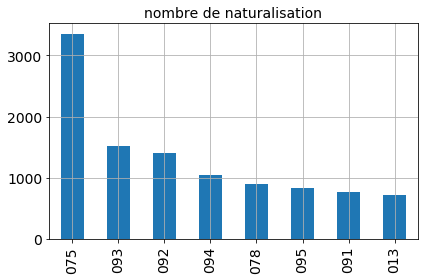

In [6]:
df["dep"].value_counts()[:8].plot(kind="bar", grid=True, title="nombre de naturalisation")
plt.tight_layout()

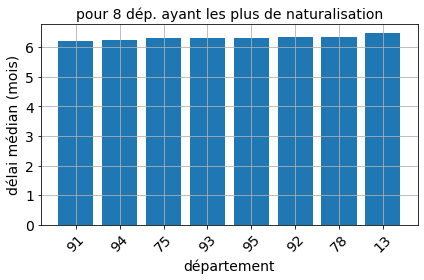

In [7]:
n_deps = 8
deps = df["dep"].value_counts()[:n_deps].index
delai = np.zeros(n_deps)
for i, dep in enumerate(deps):
    delai[i] = df[df["dep"] == dep]["delai"].median()
idx = np.argsort(delai)
deps_ = np.array([dep[1:] for dep in deps])
plt.bar(deps_[idx], delai[idx])
plt.xlabel("département")
plt.ylabel("délai médian (mois)")
plt.xticks(rotation=45)
plt.title(f"pour {n_deps} dép. ayant les plus de naturalisation")
plt.grid()
plt.tight_layout()

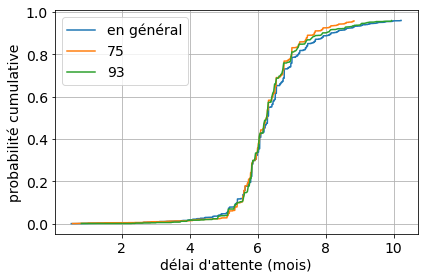

In [8]:
def duration_dep(dep):
    return df[df["dep"] == dep]["delai"]

def plot_duration_CDF(durations, labels):
    for duration, label in zip(durations, labels):
        y, x = np.histogram(duration, bins=len(duration), density=True)
        cdf = np.cumsum(y / y.sum())
        idx = np.where(cdf < 0.96)[0][-1]
        plt.plot(x[:idx], cdf[:idx], label=label)
    plt.xlabel("délai d'attente (mois)")
    plt.ylabel("probabilité cumulative")
    plt.grid()
    plt.legend()
    plt.tight_layout()

durations = [df["delai"]] + [duration_dep(x) for x in deps[:2]]
labels = ["en général"] + list(deps_[:2])
plot_duration_CDF(durations, labels)